<a href="https://colab.research.google.com/github/JessicaVicentini99/fake_br_corpus_lime/blob/main/Lime_Experimento_Final_Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForPreTraining  # Or BertForPreTraining for loading pretraining heads


In [ ]:
import tensorflow as tf
# from transformers import AutoTokenizer, TFAutoModelForSequenceClassification #TFBertForSequenceClassification
from transformers import AutoModel, AutoTokenizer, BertTokenizer, BertModel, TFAutoModelForSequenceClassification #TFBertForSequenceClassification
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import datetime
import os
import json
import time
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
import csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create Directories

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

In [ ]:
def create_directories(base_path):
  directories = {
    'models_path': base_path + '/models',
    'checkpoints_path': base_path + '/checkpoints',
    'metrics_path': base_path + '/metrics',
    'classification_report_path': base_path + '/metrics/classification_report',
    'graphs_path': base_path + '/metrics/graphs',
    'history_path': base_path + '/metrics/history',
    'lime_explanations': base_path + '/lime_explanations',
    'lime_html': base_path + '/lime_explanations/lime_html',
    'lime_html_1_1': base_path + '/lime_explanations/lime_html_1_1',
    'lime_html_0_0': base_path + '/lime_explanations/lime_html_0_0',
    'lime_html_1_0': base_path + '/lime_explanations/lime_html_1_0',
    'lime_html_0_1': base_path + '/lime_explanations/lime_html_0_1',
  }
  for name, folder_path in directories.items():
    create_dir(folder_path)
  return directories

In [ ]:
base_path = '/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/Experimentos Pos Qualificacao/Fake_Br_corpus_novo_experimento'

In [ ]:
create_dir(base_path)

In [ ]:
directories = create_directories(base_path)

## Geracao do nome do modelo

In [ ]:
def generate_model_name(models_path):
  model_files = os.listdir(models_path)
  if model_files:
    model_files.sort(reverse=True)
    last_model_index = int(model_files[0].split('_')[1])
    model_index = last_model_index + 1
  else:
    model_index = 1
  timestamp = datetime.datetime.now().strftime('%d_%m_%Y-%H_%M')
  model_save_name = f"model_{model_index}__{timestamp}"
  return model_save_name

In [ ]:
def generate_metrics_files_name(model_name, directories):
  files_name = {
    'model': directories['models_path'] + '/' + model_name + '.h5',
    'checkpoint': directories['checkpoints_path'] + '/' + model_name + '_checkpoint-{epoch:02d}.h5',
    'metrics_csv': directories['metrics_path'] + '/models_metrics.csv',
    'classification_report_txt': directories['classification_report_path'] + '/' + model_name + '.txt',
    'classification_report_json': directories['classification_report_path'] + '/' + model_name + '.json',
    'graph_acc': directories['graphs_path'] + '/' + model_name + '_acc.png',
    'graph_loss': directories['graphs_path'] + '/' + model_name + '_loss.png',
    'graph_acc_and_loss': directories['graphs_path'] + '/' + model_name + '_acc_and_loss.png',
    'confusion_matrix': directories['graphs_path'] + '/' + model_name + '_confusion_matrix.png',
    'history': directories['history_path'] + '/' + model_name + '_history.json',
    'lime_explanations': directories['lime_explanations'] + '/lime_explanations.csv',
  }
  return files_name

In [ ]:
model_save_name = generate_model_name(directories['models_path'])
files_name = generate_metrics_files_name(model_save_name, directories)

# Model Configs

In [ ]:
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased' #'bert-base-uncased'
MAX_LEN = 200

BATCH_SIZE = 240
EPOCHS = 30
LEARNING_RATE = 1e-6 #3e-5
# LEARNING_RATE = 1e-5 #3e-5
DROPOUT_RATE = 0.1

# Load Dataset



In [ ]:
def load_dataset():
  dataset = pd.read_csv(
          "/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/full_text_fake_br.csv",
          usecols=['label', 'content'],
          encoding='utf-8'
        )
  # print(dataset['label'].unique())
  # class_mapping = {'fake': 0, 'True': 1}
  # dataset['label'] = dataset['label'].map(class_mapping)
  return dataset

In [ ]:
dataset = load_dataset()

In [ ]:
MAX_LEN=(dataset['content'].str.len().max())-2

In [ ]:
MAX_LEN

46082

In [ ]:
# MAX_LEN=200

In [ ]:
MAX_LEN=512

In [ ]:
dataset["label"]=dataset["label"].astype("int")

In [ ]:
dataset.head()

,content,label
0,Ex de Luiza Brunet é ouvido em audiência do ca...,1
1,Mercosul suspende direitos políticos da Venezu...,1
2,Relator diz que concessão de asilo a Battisti ...,1
3,"Ele não precisa ser caçado, diz advogado do go...",1
4,Petrobras tem interesse em encontrar parceiros...,1


In [ ]:
dataset["label"].unique()


array([1, 0])

## Divisao Dataset

In [ ]:
train,test = train_test_split(dataset,test_size=0.2,random_state=42,stratify=dataset["label"])

In [ ]:
print(train.shape,test.shape)

(5760, 2) (1440, 2)


In [ ]:
test_df = test.copy()
test_df.to_csv('/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/amostras_de_teste.csv', index=False)

# Load Model

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
tr = train["content"]


In [ ]:
tr[0]

'Ex de Luiza Brunet é ouvido em audiência do caso no qual é acusado de agressão. Lírio Parisotto é acusado de duas lesões corporais contra a modelo: em 2015 e 2016. Outras duas testemunhas, que faltaram em audiência do ano passado, também prestaram depoimento no Fórum da Barra Funda..  O empresário Lírio Parisotto foi ouvido nesta segunda-feira (13) ao Fórum Criminal da Barra Funda, na Zona Oeste de São Paulo, em nova audiência do caso no qual ele é julgado pela acusação de agredir a ex-mulher, a atriz Luiza Brunet. Parisotto não quis falar com a imprensa. A segunda audiência de instrução durou cerca de duas horas. Além do empresário, prestaram depoimento um perito e uma mulher que presenciou uma viagem do casal para o exterior. O advogado de Parisotto, Celso Vilardi, comentou o depoimento do empresário: "Ele tem uma versão só, nunca mentiu. Uma versão harmônica", disse. Ele questiona as provas apresentadas pela acusação: "Uma hora o atestado médico fala em fratura do dedo. Agora, a ac

In [ ]:
# encoded_input = tokenizer.encode_plus(text=tr[0], max_length=MAX_LEN, truncation=True, return_tensors='tf')


In [ ]:
# encoded_input

# Tratamento das entradas

In [ ]:
# def get_masks(text, max_length):
#     """Mask for padding"""
#     tokens = tokenizer.tokenize(text)
#     length = len(tokens)
#     if length > max_length:
#       tokens = tokens[:max_length]
#     tokens = ["[CLS]"] + tokens + ["[SEP]"]


#     return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))


In [ ]:
# vec_get_masks = np.vectorize(get_masks, signature = '(),()->(n)')

In [ ]:
# def get_segments(text, max_length):
#     """Segments: 0 for the first sequence, 1 for the second"""
#     tokens = tokenizer.tokenize(text)
#     length = len(tokens)
#     if length > max_length:
#         tokens = tokens[:max_length]
#     tokens = ["[CLS]"] + tokens + ["[SEP]"]

#     segments = []
#     current_segment_id = 0
#     with_tags = ["[CLS]"] + tokens + ["[SEP]"]
#     token_ids = tokenizer.convert_tokens_to_ids(tokens)

#     for token in tokens:
#         segments.append(current_segment_id)
#         if token == "[SEP]":
#             current_segment_id = 1
#     return np.asarray(segments + [0] * (max_length - len(tokens)))

In [ ]:
# vec_get_segments = np.vectorize(get_segments, signature = '(),()->(n)')


In [ ]:
# def get_ids(text, tokenizer, max_length):
#     """Token ids from Tokenizer vocab"""
#     tokens = tokenizer.tokenize(text)
#     length = len(tokens)
#     if length > max_length:
#       tokens = tokens[:max_length]
#     tokens = ["[CLS]"] + tokens + ["[SEP]"]


#     token_ids = tokenizer.convert_tokens_to_ids(tokens)
#     input_ids = np.asarray(token_ids + [0] * (max_length - len(tokens)))
#     return input_ids

In [ ]:
# vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')


In [ ]:
# def prepare(text_array, tokenizer, max_length = 200):

#     ids = vec_get_ids(text_array,
#                       tokenizer,
#                       max_length).squeeze()
#     masks = vec_get_masks(text_array,
#                       max_length).squeeze()
#     segments = vec_get_segments(text_array,
#                       max_length).squeeze()

#     return ids, segments, masks

In [ ]:
train.head()

,content,label
4264,Marqueteiro do PT está inquieto na cadeia. Ele...,0
3482,População busca fósseis de dinossauros em Nova...,1
4757,CHEGA! Vitória de Trump serve de aviso para a ...,0
1942,Tribunal nega liberdade para ex-gerente de Eng...,1
327,Chuva recorde no Rio causa 4 mortes e deixa es...,1


In [ ]:
train["content"][0]

'Ex de Luiza Brunet é ouvido em audiência do caso no qual é acusado de agressão. Lírio Parisotto é acusado de duas lesões corporais contra a modelo: em 2015 e 2016. Outras duas testemunhas, que faltaram em audiência do ano passado, também prestaram depoimento no Fórum da Barra Funda..  O empresário Lírio Parisotto foi ouvido nesta segunda-feira (13) ao Fórum Criminal da Barra Funda, na Zona Oeste de São Paulo, em nova audiência do caso no qual ele é julgado pela acusação de agredir a ex-mulher, a atriz Luiza Brunet. Parisotto não quis falar com a imprensa. A segunda audiência de instrução durou cerca de duas horas. Além do empresário, prestaram depoimento um perito e uma mulher que presenciou uma viagem do casal para o exterior. O advogado de Parisotto, Celso Vilardi, comentou o depoimento do empresário: "Ele tem uma versão só, nunca mentiu. Uma versão harmônica", disse. Ele questiona as provas apresentadas pela acusação: "Uma hora o atestado médico fala em fratura do dedo. Agora, a ac

In [ ]:
tr = train["content"]
te = test["content"]

In [ ]:
# MAX_LEN=15000

In [ ]:
encoded_samples_train = tokenizer.batch_encode_plus(
    tr,
    add_special_tokens=True,  # Adicione tokens especiais como [CLS], [SEP]
    max_length=MAX_LEN,           # Defina o comprimento máximo desejado
    padding="max_length",     # Preencha/trunce para o comprimento máximo
    truncation=True,          # Truncar a sequência se exceder o comprimento máximo
    return_tensors="tf"       # Retorne tensores do PyTorch
)

In [ ]:
encoded_samples_test = tokenizer.batch_encode_plus(
    te,
    add_special_tokens=True,  # Adicione tokens especiais como [CLS], [SEP]
    max_length=MAX_LEN,           # Defina o comprimento máximo desejado
    padding="max_length",     # Preencha/trunce para o comprimento máximo
    truncation=True,          # Truncar a sequência se exceder o comprimento máximo
    return_tensors="tf"       # Retorne tensores do PyTorch
)

In [ ]:
# encoded_samples = []


In [ ]:
# for sample in tr:
#     encoded_sample = tokenizer.encode_plus(
#         sample,
#         add_special_tokens=True,  # Adicione tokens especiais como [CLS], [SEP]
#         max_length=MAX_LEN,           # Defina o comprimento máximo desejado
#         padding="max_length",     # Preencha/trunque para o comprimento máximo
#         truncation=True,          # Truncar a sequência se exceder o comprimento máximo
#         return_tensors="tf"       # Retorne tensores do PyTorch
#     )
#     encoded_samples.append(encoded_sample)

In [ ]:
# ids_train, segments_train, masks_train = prepare(tr,
#                                                  tokenizer, MAX_LEN)
# ids_test, segments_test, masks_test = prepare(te,
#                                                tokenizer, MAX_LEN)

In [ ]:
    # ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 46074), found shape=(24, 46096)

In [ ]:
# max_id_length = max([len(ids) for ids in ids_train])
# print("Tamanho máximo de ids_train:", max_id_length)

In [ ]:
# max_id_length = max([len(ids) for ids in masks_train])
# print("Tamanho máximo de ids_train:", max_id_length)

Token indices sequence length is longer than the specified maximum sequence length for this model (914 > 512). Running this sequence through the model will result in indexing errors

# Criacao do Modelo

In [ ]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
segment_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32,name="segment_ids")
bert_model = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
  )
output = bert_model([input_word_ids, input_mask, segment_ids])
# output = output
# output = tf.keras.layers.Dense(32,activation='relu')(output)
# output = tf.keras.layers.Dropout(DROPOUT_RATE)(output)
logits = output.logits  # Acessa os logits da saída da camada BERT
probs = tf.keras.layers.Softmax()(logits)

# output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[probs])


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
# loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
# model.compile(
#             optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
#             loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])



In [ ]:
model.compile(Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  108924674  ['input_word_ids[0][0]',         
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'input_mask[0][0]',         

# Carregar pesos do modelo

In [ ]:
# model.load_weights('/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/Fake_Br_corpus_second_experiment/models/model_2__28_05_2023-18_49.h5')


# Treinamento do Modelo

In [ ]:
# train["label"] = train["label"]

In [ ]:
# encoded_samples_train['input_ids']

In [ ]:
# input_word_ids = encoded_samples_train['input_ids']
# input_mask = encoded_samples_train['attention_mask'],
# segment_ids = encoded_samples_train['token_type_ids']

In [ ]:
# labels = np.array(train.label)

In [ ]:
# labels = labels.astype(int)  # Converte para inteiros
# labels = tf.keras.utils.to_categorical(labels, num_classes=2)


In [ ]:
# labels = labels.astype(int)  # Converte para inteiros


In [ ]:
encoded_samples_train

{'input_ids': <tf.Tensor: shape=(5760, 512), dtype=int32, numpy=
array([[  101,   496,  6685, ...,     0,     0,     0],
       [  101,  4150,  1163, ...,   481,   291,   102],
       [  101,   187, 22340, ...,     0,     0,     0],
       ...,
       [  101, 12075,   125, ...,  3946,   123,   102],
       [  101, 14215,  5054, ...,     0,     0,     0],
       [  101, 11124,  1331, ...,   771,  2541,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(5760, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(5760, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1]], dtype=in

In [ ]:
start_time = time.time()


history = model.fit(
          x={
              "input_word_ids": encoded_samples_train["input_ids"],
              "input_mask": encoded_samples_train["attention_mask"],
              "segment_ids": encoded_samples_train["token_type_ids"]
          },
          y=train['label'],
          validation_split=0.20,
          epochs = EPOCHS,
          batch_size = 24
          )
end_time = time.time()


Epoch 1/30
192/192 [==============================] - 120s 420ms/step - loss: 0.5754 - accuracy: 0.8047 - val_loss: 0.3795 - val_accuracy: 0.9514
Epoch 2/30
192/192 [==============================] - 74s 385ms/step - loss: 0.2288 - accuracy: 0.9737 - val_loss: 0.1362 - val_accuracy: 0.9748
Epoch 3/30
192/192 [==============================] - 73s 378ms/step - loss: 0.0975 - accuracy: 0.9837 - val_loss: 0.0910 - val_accuracy: 0.9809
Epoch 4/30
192/192 [==============================] - 71s 367ms/step - loss: 0.0600 - accuracy: 0.9887 - val_loss: 0.0747 - val_accuracy: 0.9835
Epoch 5/30
192/192 [==============================] - 67s 349ms/step - loss: 0.0451 - accuracy: 0.9913 - val_loss: 0.0636 - val_accuracy: 0.9826
Epoch 6/30
192/192 [==============================] - 67s 349ms/step - loss: 0.0298 - accuracy: 0.9944 - val_loss: 0.0565 - val_accuracy: 0.9861
Epoch 7/30
192/192 [==============================] - 66s 341ms/step - loss: 0.0232 - accuracy: 0.9965 - val_loss: 0.0471 - val_a

https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#8.-BERT

In [ ]:
model.save_weights(
    '/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/Fake_Br_corpus_novo_experimento_2/weights'
)


In [ ]:
model.save(
    '/content/drive/MyDrive/Arquivos/Mestrado/Qualificação/Fake_Br_corpus_novo_experimento_2/full_model'
)

# Avaliação do modelo

## Excucao do modelo no conjunto de testes

In [ ]:
test["label"] = test["label"].astype(float)

In [ ]:
test_loss, test_acc = model.evaluate( x={
              "input_word_ids": encoded_samples_test["input_ids"],
              "input_mask": encoded_samples_test["attention_mask"],
              "segment_ids": encoded_samples_test["token_type_ids"]
          },
          y=test['label'])


45/45 [==============================] - 8s 125ms/step - loss: 0.0918 - accuracy: 0.9840


In [ ]:
# threshold = 0.5


In [ ]:
# y_pred = model.predict([ids_test, masks_test, segments_test])

# y_pred_bool = np.argmax(y_pred, axis=1)


# Geração de Relatorios

In [ ]:
y_pred = model.predict( x={
              "input_word_ids": encoded_samples_test["input_ids"],
              "input_mask": encoded_samples_test["attention_mask"],
              "segment_ids": encoded_samples_test["token_type_ids"]
          })
y_pred_bool = np.argmax(y_pred, axis=1)

45/45 [==============================] - 7s 122ms/step


In [ ]:
y_pred_bool

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True class')
  plt.xlabel('Predicted class')
  return hmap

In [ ]:
def generate_classification_report(y_pred, y_pred_bool, test, files_name):
  # y_pred = model.predict([ids_test, masks_test, segments_test])
  # y_pred_bool = np.argmax(y_pred, axis=1)

  report = classification_report(y_pred_bool, test["label"])
  report_dict = classification_report(y_pred_bool, test["label"], output_dict=True)
  # df_report = pd.DataFrame(report_dict).transpose()

  with open(files_name['classification_report_json'], 'w') as f:
    json.dump(report_dict, f)

  with open(files_name['classification_report_txt'], 'w') as f:
    f.write(report)

  print(report)

  # CLASSIFICATION REPORT
  cm = confusion_matrix(test["label"], y_pred_bool)
  df_cm = pd.DataFrame(cm, index=['0','1'], columns=['0','1'])
  heatmap = show_confusion_matrix(df_cm)
  heatmap.figure.savefig(files_name['confusion_matrix'])


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       707
           1       0.99      0.98      0.98       733

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440



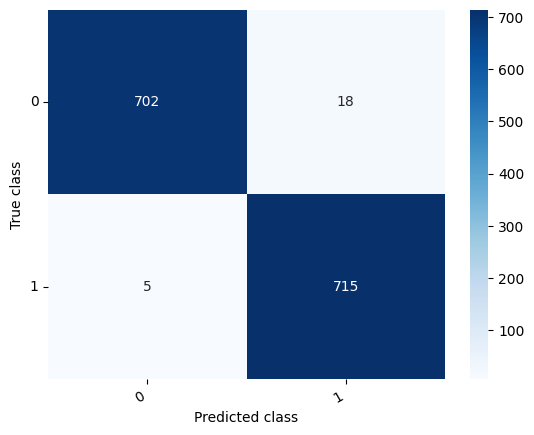

In [ ]:
generate_classification_report(y_pred, y_pred_bool, test, files_name)

# Salvar metricas do modelo

In [ ]:
def save_model_metrics(model_save_name, files_name, history, start_time,
                       end_time, epochs, batch_size, learning_rate, dropout,
                       test_loss, test_acc, with_stop_words):
  # Calcula o tempo de execução em segundos
  time_seconds = round(end_time - start_time, 2)

  # Calcula o tempo de execução em minutos
  time_minutes = round(time_seconds / 60, 2)
  metrics = {
    'model': model_save_name,
    'loss': history.history['loss'][-1],
    'accuracy': history.history['accuracy'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_accuracy': history.history['val_accuracy'][-1],
    'time': str(end_time - start_time),
    'time_seconds': time_seconds,
    'time_minutes': time_minutes,
    'epochs': epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'dropout': dropout,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'with_stop_words': with_stop_words
  }

  if os.path.isfile(files_name['metrics_csv']):
      # Se o arquivo existe, leia-o em um DataFrame
      df_metrics = pd.read_csv(files_name['metrics_csv'])
  else:
      # Se o arquivo não existe, crie um DataFrame vazio
      df_metrics = pd.DataFrame()

  df_metrics = df_metrics.append(metrics, ignore_index=True)
  df_metrics.to_csv(files_name['metrics_csv'], index=False)

  with open(files_name['history'], 'w') as f:
    json.dump(history.history, f)

  display(df_metrics.tail())



In [ ]:
save_model_metrics(model_save_name, files_name, history, start_time, end_time,
                   EPOCHS, BATCH_SIZE, LEARNING_RATE, DROPOUT_RATE, test_loss,test_acc, True)


<ipython-input-79-f730f8fdfb92>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_metrics = df_metrics.append(metrics, ignore_index=True)


,model,loss,accuracy,val_loss,val_accuracy,time,time_seconds,time_minutes,epochs,batch_size,learning_rate,dropout,test_loss,test_acc,with_stop_words
0,model_1__29_08_2023-11_18,0.000719,1.0,0.056528,0.986111,1917.805606,1917.81,31.96,30,24,0.000001,0.1,0.069621,0.986806,True
1,model_1__05_09_2023-17_21,0.000399,1.0,0.079034,0.985243,1995.0693562030792,1995.07,33.25,30,240,0.000001,0.1,0.091810,0.984028,True


# salvar grafico do treinamento

In [ ]:
def save_model_graphs(model_save_name, files_name, history):
  epochs_range = list(range(1, len(history.history['accuracy'])+1))
  # cria o gráfico de Accuracy
  plt.plot(epochs_range, history.history['accuracy'])
  plt.plot(epochs_range, history.history['val_accuracy'])
  plt.title('Training and Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')

  # Salva figura
  plt.savefig(files_name['graph_acc'])
  plt.show()

  # cria o gráfico de Loss
  plt.plot(epochs_range, history.history['loss'])
  plt.plot(epochs_range, history.history['val_loss'])
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')

  # Salva figura
  plt.savefig(files_name['graph_loss'])
  plt.show()

  # Definir o tamanho da figura
  fig, axs = plt.subplots(1, 2, figsize=(15,5))

  # Plotar o gráfico de loss no primeiro subplot
  axs[0].plot(epochs_range, history.history['loss'], label='train_loss')
  axs[0].plot(epochs_range, history.history['val_loss'], label='val_loss')
  axs[0].set_title('Model Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Loss')
  axs[0].legend()

  # Plotar o gráfico de acurácia no segundo subplot
  axs[1].plot(epochs_range, history.history['accuracy'], label='train_acc')
  axs[1].plot(epochs_range, history.history['val_accuracy'], label='val_acc')
  axs[1].set_title('Model Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Accuracy')
  axs[1].legend()

  # Salvar a figura em um arquivo
  plt.savefig(files_name['graph_acc_and_loss'])

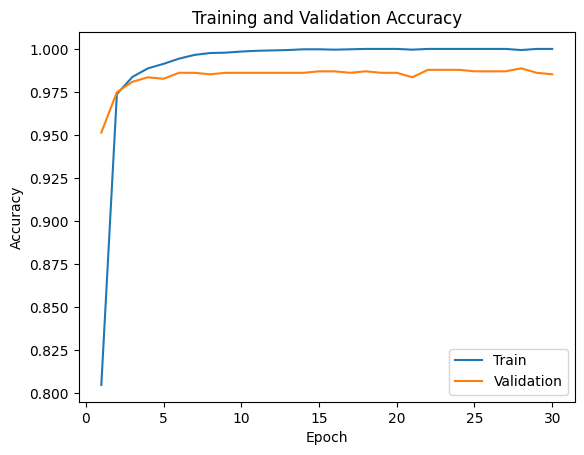

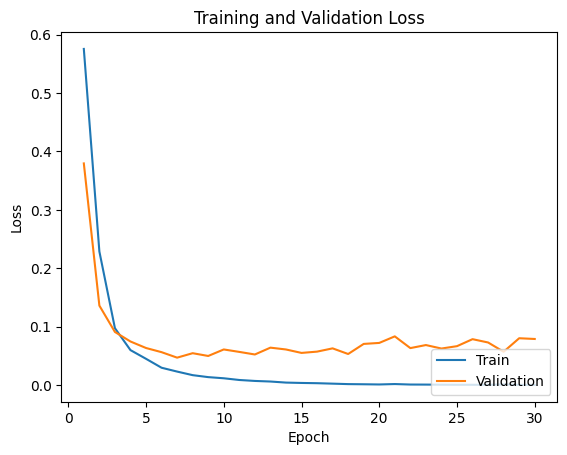

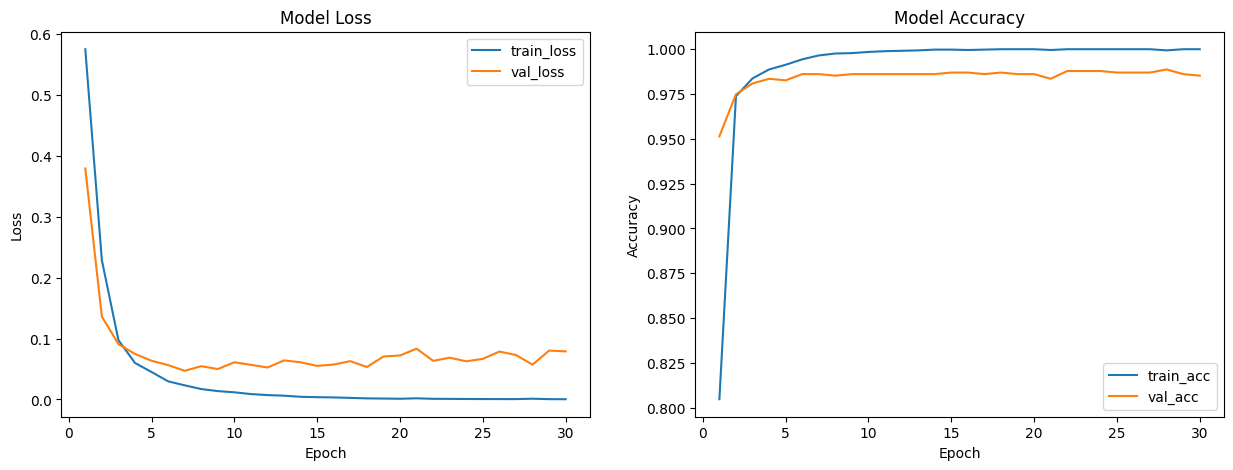

In [ ]:
save_model_graphs(model_save_name, files_name, history)

In [ ]:
# np.shape(ids_test)

In [ ]:
# y_pred

In [ ]:
# # y_pred_bool = np.where(y_pred >= threshold, 1, 0)
# y_pred_bool = np.argmax(y_pred, axis=1)
# from sklearn.metrics import classification_report

# print(classification_report(y_pred_bool, test["label"]))

In [ ]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sns


In [ ]:
# np.shape(y_pred_bool)

# LIME

https://www.kaggle.com/code/arinjaypathak/fine-tuned-bert-lime-youtube-comment-sentiment

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1fd5fc889c27c9b91c81d2cef381bf0079a96c81d8a90dd2d6de843b8096a8b8
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
from lime.lime_text import LimeTextExplainer

## LimeTestes

## Funçao de predicao

In [ ]:
def predict_proba(arr):
    # processed=[]
    # for i in arr:
    #     processed.append(i)
    id,segment,mask=prepare(arr,tokenizer,max_length=200)
    pred=model.predict([id,mask,segment])
    return pred
    # id, segment, mask = prepare([arr], tokenizer, max_length=200)
    # pred = model.predict([id, mask, segment], batch_size=1)
    # return pred

In [ ]:
def save_lime_explain(model_save_name, files_name, pos, sample_index, sample_text, original_class, prediction_class):

  metrics = {
    'model_name': model_save_name,
    'pos': pos,
    'index': sample_index,
    'real_class': original_class,
    'pred_class': prediction_class,
    'text': sample_text
  }

  if os.path.isfile(files_name['lime_explanations']):
      # Se o arquivo existe, leia-o em um DataFrame
      df_lime = pd.read_csv(files_name['lime_explanations'])
  else:
      # Se o arquivo não existe, crie um DataFrame vazio
      df_lime = pd.DataFrame()

  df_lime = df_lime.append(metrics, ignore_index=True)
  df_lime.to_csv(files_name['lime_explanations'], index=False)
  display(df_lime.tail())


In [ ]:
def explain_instance(directories, test, y_pred_bool, model_save_name, files_name):
  class_names = [0, 1]
  explainer = LimeTextExplainer(class_names=class_names)
  i = 0
  for index, row in test.iterrows():
    if i <= 682:
      i = i + 1
      continue
    file_name = '/' + model_save_name + '_' + str(i) + '_pos_' + str(index) + '_index_'+ str(int(row['label'])) + '_orig_class_'+ str(y_pred_bool[i]) +'pred_class__lime_explain'
    html_path = 'lime_html_' +  str(int(row['label'])) + '_' + str(y_pred_bool[i])
    # explicando instancia
    exp = explainer.explain_instance(row['content'], predict_proba)
    exp.show_in_notebook(text=True)
    # Salvando html do lime
    exp.save_to_file(directories[html_path] + file_name + '.html')
    # salvando explicancao como csv
    result_list = exp.as_list()
    csv_file_name = directories[html_path] + file_name + '.csv'
    with open(csv_file_name, mode='w', newline='') as result_file:
      writer = csv.writer(result_file)
      writer.writerows(result_list)
    # salvando texto e predicao e classe real no csv com todas as amostras
    save_lime_explain(model_save_name, files_name, i, index, row['content'], row['label'], y_pred_bool[i])
    i = i + 1
    print(i)
    print('-------------------------------------')


In [ ]:
explain_instance(directories, test, y_pred_bool, model_save_name, files_name)

In [ ]:
def explain_instance(explainer, directories, test):


# experimentos de teste Lime

In [ ]:
# y_pred = model.predict([ids_test, masks_test, segments_test])
# row_index = dataset.loc[dataset['label'] == 0].index[0]
# row = dataset.loc[row_index, :]
# ids_train, segments_train, masks_train = prepare(tr,
#                                                  tokenizer, MAX_LEN)

## funcao de predicao

In [ ]:
def predict_proba_test(arr):
    # processed=[]
    # for i in arr:
    #     processed.append(i)
    id,segment,mask=prepare(arr,tokenizer,max_length=200)
    pred=model.predict([id,mask,segment])
    return pred
    # id, segment, mask = prepare([arr], tokenizer, max_length=200)
    # pred = model.predict([id, mask, segment], batch_size=1)
    # return pred

In [ ]:
row_index

In [ ]:
dataset.iloc[4,:]

In [ ]:
# sample_text = dataset.iloc[4,:]
sample_text = dataset['content'][4]
sample_text = dataset['content'][4]
      # dataset['content'][3600]

samples = [
     dataset['content'][4],
     dataset['content'][3600]
]

In [ ]:
samples = [
     dataset['content'][6660],
]

In [ ]:
dataset.iloc[3600,:]

In [ ]:
test['content'][6660]

In [ ]:
test["label"]

In [ ]:
resp = predict_proba_test(samples)

In [ ]:
resp

In [ ]:
resp

In [ ]:
resp = predict_proba(dataset['content'][4])

In [ ]:
# test = np.where(resp >= threshold, 1, 0)
np.argmax(resp, axis=0)

## instanciando explainer

In [ ]:
class_names = [0, 1]
explainer = LimeTextExplainer(class_names=class_names)


In [ ]:
explainer.explain_instance(dataset['content'][3600],predict_proba).show_in_notebook(text=True)


In [ ]:
explainer.explain_instance(dataset['content'][4],predict_proba).show_in_notebook(text=True)
